Creating the Initial Conditions for our BH/DM Halo Simulation!

In [6]:
from pygadgetreader import *
# This one works!

In [7]:
import scipy.stats as st
import numpy as np
import random

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from math import isnan
#from math import gamma
from scipy.special import gamma
from astropy import units as u
from astropy import constants as c

%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
"""Edited to respect notational conventions"""
G = c.G
U_ENERGY = u.solMass * u.parsec**2 * u.s**-2
M_IMBH = 1e4 * u.solMass
RHO_SP = 226. * u.solMass / u.parsec**3
GAMMA_SP = 2.25  # Dimensionless slope parameter.
R_IN = 1.914e-9 * u.parsec
R_SP = 1.17097 * u.parsec
N_PARTICLES = 2**16

In [13]:
# EQUATION (2.5)
def mass_dm(r):
    m = ((4*np.pi*RHO_SP*R_SP**GAMMA_SP)/(3-GAMMA_SP))*r**(3-GAMMA_SP)
    return m

In [14]:
mass_dm(R_SP) - mass_dm(R_IN)

<Quantity 6079.86917282 solMass>

In [5]:
"""Sampling from 1d distributions"""
def sample_cdf(pdf, xmin, xmax, n_bins=1000, log=False):
    if log:
        binner = np.geomspace
    else:
        binner = np.linspace
    edges = binner(xmin, xmax, n_bins)
    bins = np.vstack((edges[:-1], edges[1:])).T
    centers = np.mean(bins, axis=1)
    widths = bins[:, 1] - bins[:, 0]
    pdf_samples = pdf(centers)
    cdf_samples = np.cumsum(pdf_samples * widths)
    cdf_samples /= cdf_samples[-1]
    return np.vstack((centers, cdf_samples)).T

def inverse_cdf(*args, **kwargs):
    iy, ix = sample_cdf(*args, **kwargs).T
    return interp1d(ix, iy, fill_value='extrapolate')

def sample_icdf(icdf, n_samples):
    range_samples = np.random.uniform(size=n_samples)
    return icdf(range_samples)

def sample(pdf, xmin, xmax, n_samples, **kwargs):
    icdf = inverse_cdf(pdf, xmin, xmax, **kwargs)
    return sample_icdf(icdf, n_samples)

In [6]:
def radius_pdf(r):
    # Takes dimensionless r in pc
    rho_dm = RHO_SP.to(u.solMass / u.pc**3).value * \
        (R_SP.to(u.pc).value/r)**GAMMA_SP
    return rho_dm * r**2

Wall time: 19.9 s


(<Quantity [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            61.31940456,  7.04731755,  9.71921073, 12.56635814, 12.13150359,
             4.68069524,  4.15475141,  3.84760253,  2.9838115 ,  2.04065306,
             1.56729541,  1.24220126,  0.92637796,  0.71759671]>,
 <Quantity [1.91400000e-09, 5.55130088e-09, 1.61008054e-08, 4.66982315e-08,
            1.35441972e-07, 3.92831315e-07, 1.13935466e-06, 3.30454574e-06,
            9.58439273e-06, 2.77982486e-05, 8.06251003e-05, 2.33842315e-04,
            6.78228343e-04, 1.96711055e-03, 5.70534093e-03, 1.65475779e-02,
            4.79940355e-02, 1.39200278e-01, 4.03731779e-01, 1.17097000e+00]>,
 <a list of 19 Patch objects>)

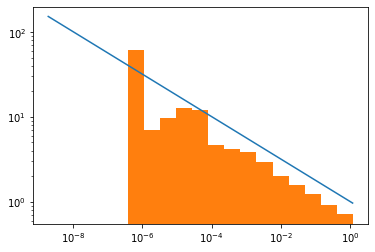

In [7]:
%%time
radius = sample(radius_pdf, R_IN/u.pc, R_SP/u.pc, N_PARTICLES, n_bins=int(1e8), log=True)
plt.loglog()
r_values = np.geomspace(R_IN/u.pc, R_SP/u.pc, 20)
p_values = radius_pdf(r_values)
plt.plot(r_values, p_values / 320)
plt.hist(radius, density=True, bins=r_values);

In [8]:
def random_unit_vector(n_samples):
    vector = np.random.normal(size=3*n_samples).reshape((n_samples, 3))
    return vector / np.linalg.norm(vector, axis=1)[:, np.newaxis]

In [9]:
%%time
unit_vectors = random_unit_vector(len(radius))

Wall time: 12 ms


In [10]:
%%time
positions = radius[:, np.newaxis] * unit_vectors

Wall time: 2 ms


Wall time: 173 ms


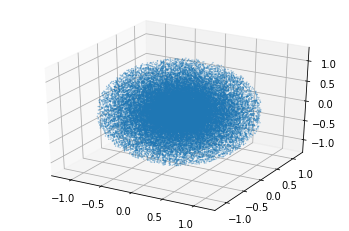

In [11]:
%%time
ax = plt.axes(projection='3d')
ax.scatter3D(*positions.T, s=0.1);

Let's randomize the velocities of each DM particle! See eq. (S5) of [1905.04686](https://arxiv.org/pdf/1905.04686.pdf).

In [12]:
def fvr(v, r):
    # Dimensionless inputs and outputs
    vmax = np.sqrt(2 * G * M_IMBH / r).to(u.pc**(3./2.) / u.s).value
    return 4 / np.sqrt(np.pi) * gamma(GAMMA_SP+1) / gamma(GAMMA_SP-1./2.) * \
        v**2 / vmax**(2*GAMMA_SP) * (vmax**2 - v**2) ** (GAMMA_SP - 3./2.)

Sample from this distribution separately for each $r$ value:

In [13]:
%%time
speed = np.zeros_like(radius)
for i, r in enumerate(radius):
    vmax = np.sqrt(2 * G * M_IMBH / (r*u.pc)).to(u.pc / u.s).value
    v_pdf = lambda v: fvr(v, r)
    speed[i] = sample(v_pdf, 0, vmax, 1)

Wall time: 1min 4s


Now give these velocities random directions:

In [14]:
%%time
unit_vectors = random_unit_vector(len(speed))
velocities = speed[:, np.newaxis] * unit_vectors

Wall time: 13 ms


Now we have position and velocity arrays:

In [32]:
positions
np.save(".//saved arrays//positions.npy",positions)

In [33]:
velocities
np.save(".//saved arrays//velocities.npy",velocities)

Note that for no particular reason, the units are parsecs and _seconds_. This is why the velocities look so low. If we were to convert them to km/s, we would get:

In [17]:
(velocities * u.pc / u.s).to(u.km / u.s).value

array([[ -2.303291  ,   2.63972735,  -3.08034705],
       [ -5.84353552,  -6.48908817,  -4.99304323],
       [ -4.73154688,  -1.90158701,   6.5934105 ],
       ...,
       [-28.35347648,  -5.50779169,  -4.36875956],
       [ -7.9003124 ,  -7.2246328 , -17.70691659],
       [ -3.5465135 ,   1.18395634,  -2.69527693]])